In [39]:
#  ───────────────────────── 0. Imports & setup ─────────────────────────
import os, json, time, warnings, math, pandas as pd
from pathlib import Path
from datetime import datetime
warnings.filterwarnings("ignore")

from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage, SystemMessage
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import tiktoken                                    
from dotenv import load_dotenv

# ——— API / model ----------------------------------------------------------
load_dotenv()
LLM_NAME = "gpt-4o-mini"
API_KEY  = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model_name=LLM_NAME,
                 temperature=0.0,
                 max_tokens=128)                   # plenty for 2-field JSON

enc = tiktoken.encoding_for_model(LLM_NAME)       # cost accounting helper
PRICE_PER_1K = 0.0005                             # $ for gpt-4o-mini 2025-05

In [40]:
#  ───────────────────────── 1. Load Part-2 transcripts ─────────────────
df = pd.read_csv("../results/whisper_transcripts.csv")   # filename, transcribed_text, emotion
texts = df["transcribed_text"].tolist()
true_emotions = df["emotion"]
print(f"{len(df)} samples loaded from Part-2 results")

# %% ───────────────────────── 2. Prompt template ─────────────────────────
PROMPT = """
You are a precise sentiment classifier.

Return **only** a valid JSON object with two keys:
  "sentiment": _exactly one of_ [`positive`, `negative`, `neutral`]
  "emotion"  : _exactly one of_ [`joy`, `sad`, `anger`,
                                 `fear`, `surprise`, `disgust`, `neutral`]

Do **not** output anything except the JSON.

Text: {text}
JSON:
"""
template = PromptTemplate.from_template(PROMPT)

SYS_MSG = SystemMessage(
    content="You are a JSON-only classifier.  If unsure, output neutral."
)

29 samples loaded from Part-2 results


In [41]:
# %% ───────────────────────── 3. LLM call helper (retry & trim) ──────────
def call_llm(text: str, max_chars: int = 400, tries: int = 3) -> str:
    """Send trimmed text to the LLM, return raw response (JSON string)."""
    short = text[:max_chars]
    msg   = HumanMessage(content=template.format(text=short))
    for attempt in range(tries):
        try:
            return llm([SYS_MSG, msg]).content
        except Exception as e:
            if attempt == tries - 1:
                raise
            time.sleep(2)    

In [42]:
# ───────────────────────── 4. Batch inference w/ cache ───────────────
CACHE = Path("../results/llm_outputs.json")
if CACHE.exists():
    outputs = json.load(CACHE.open())
    print("Loaded cached LLM outputs")
else:
    print("Calling the LLM …")
    outputs = [call_llm(t) for t in texts]
    json.dump(outputs, CACHE.open("w"))
    print("Responses cached for future runs")

Loaded cached LLM outputs


In [43]:
# ───────────────────────── 5. Parse & harmonise labels ───────────────
VALID = {"joy","sad","anger","fear","surprise","disgust","neutral"}
MAP_LLM = {"sadness": "sad"}            # if model sometimes says “sadness”

def parse_out(s: str) -> str:
    try:
        obj = json.loads(s)
        lab = MAP_LLM.get(obj["emotion"], obj["emotion"])
        return lab if lab in VALID else "neutral"
    except Exception:
        return "neutral"

pred_emotions = [parse_out(o) for o in outputs]
df["llm_emotion"] = pred_emotions

LLM macro-F1: 0.322


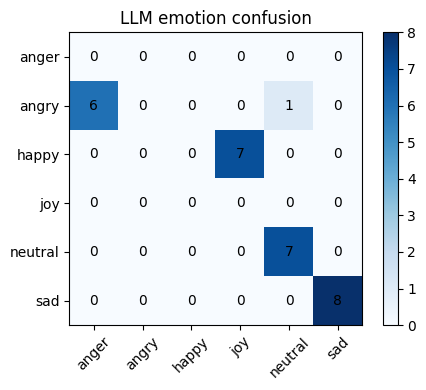

In [44]:
# ───────────────────────── 6. Evaluation & plots ─────────────────────
macro = f1_score(true_emotions, pred_emotions,
                 average="macro", zero_division=0)
print("LLM macro-F1:", round(macro, 3))

labels = sorted(set(true_emotions) | set(pred_emotions))
cm = confusion_matrix(true_emotions, pred_emotions, labels=labels)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
for (i,j),v in np.ndenumerate(cm):
    plt.text(j,i,v,ha="center",va="center")
plt.title("LLM emotion confusion"); plt.tight_layout(); plt.show()

# save per-sample metrics
run_id = datetime.utcnow().strftime("%Y%m%dT%H%M%S")
df.to_csv(f"../results/llm_metrics_{run_id}.csv", index=False)

In [45]:
# ───────────────────────── 7. Exact cost estimate ────────────────────
tot_tokens = sum(len(enc.encode(r)) for r in outputs)
cost = tot_tokens / 1000 * PRICE_PER_1K
print(f"Exact token usage: {tot_tokens:,}  ➜  ${cost:.4f}")
with open("../results/cost_estimate.txt","w") as f:
    f.write(f"{cost:.4f}\n")

Exact token usage: 513  ➜  $0.0003


In [ ]:
#  ───────────────────────── 8. Compare to Whisper baseline ────────────
# acoustic baseline macro-F1 from Part-2
base_macro = pd.read_csv("../results/whisper_metrics.csv")["macro_f1"].iloc[0]
print(f"\nWhisper+Transformer macro-F1 (Part-2): {base_macro:.3f}")
print(f"LLM macro-F1: {macro:.3f}")
plt.bar(["Acoustic", "LLM"], [base_macro, macro], color=["#5DA5DA","#F17CB0"])
for i,v in enumerate([base_macro, macro]):
    plt.text(i, v+0.01, f"{v:.2f}", ha="center")
plt.ylim(0,1); plt.ylabel("Macro-F1"); plt.title("Baseline comparison"); plt.tight_layout()
plt.show()

KeyError: 'match'